#Phase 1: Data Generation & Feature Engineering

1. Setup

In [ ]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# Config hiển thị pandas cho dễ nhìn
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Set seed để kết quả code của tôi và bạn giống nhau (reproducible)
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Cấu hình chung cho dự án
NUM_CUSTOMERS = 2000  # Số lượng khách hàng giả lập
START_DATE = datetime(2023, 1, 1)
END_DATE = datetime(2024, 12, 31)

print(f"✅ Setup hoàn tất. Sẵn sàng tạo dữ liệu cho {NUM_CUSTOMERS} khách hàng.")

✅ Setup hoàn tất. Sẵn sàng tạo dữ liệu cho 2000 khách hàng.


2. Tạo dữ liệu khách hàng (customer profiles)

In [ ]:
def generate_customers(n):
    print(f"⏳ Đang tạo hồ sơ cho {n} khách hàng...")
    data = []

    for i in range(n):
        cust_id = 1000 + i
        age = np.random.randint(22, 60)

        # Phân loại nghề nghiệp
        emp_status = np.random.choice(
            ['employed', 'self_employed', 'unemployed'],
            p=[0.70, 0.25, 0.05] # 70% đi làm cty, 25% tự do, 5% thất nghiệp
        )

        # Logic thu nhập dựa trên nghề nghiệp
        if emp_status == 'unemployed':
            monthly_income = np.random.normal(500, 100) # Thu nhập thấp
            stability_score = np.random.uniform(0.1, 0.4)
        elif emp_status == 'self_employed':
            monthly_income = np.random.normal(3500, 1500) # Biến động cao
            stability_score = np.random.uniform(0.3, 0.8)
        else:
            monthly_income = np.random.normal(4000, 800) # Ổn định
            stability_score = np.random.uniform(0.7, 0.99)

        # Làm sạch số liệu (không để thu nhập âm)
        monthly_income = max(monthly_income, 0)

        # Nguồn thu nhập phụ từ gia đình (Family Support)
        has_support = np.random.rand() > 0.7 # 30% có trợ cấp
        family_support = max(np.random.normal(500, 200), 0) if has_support else 0

        # Điểm biến động thu nhập (Volatility)
        volatility_score = np.clip((1 - stability_score) + np.random.normal(0, 0.05), 0, 1)

        # --- QUAN TRỌNG: GÁN NHÃN HÀNH VI (GROUND TRUTH) ---
        # 0: An toàn, 1: Rủi ro cao (Vay chồng chéo - Stacker)
        # Giả lập 15% user có xu hướng vay chỗ này đắp chỗ kia
        is_stacker = 1 if np.random.rand() < 0.15 else 0

        data.append([cust_id, age, emp_status, round(monthly_income, 2),
                     round(family_support, 2), round(volatility_score, 2),
                     round(stability_score, 2), is_stacker])

    # Tạo DataFrame
    df = pd.DataFrame(data, columns=[
        'customer_id', 'age', 'employment_status', 'monthly_income',
        'family_support_income', 'income_volatility_score',
        'employment_stability_score', 'is_stacker_hidden'
    ])

    return df

# Chạy hàm
df_customers = generate_customers(NUM_CUSTOMERS)
print(f"✅ Đã tạo xong {len(df_customers)} khách hàng.")
display(df_customers.head(3)) # Xem thử 3 dòng đầu

⏳ Đang tạo hồ sơ cho 2000 khách hàng...
✅ Đã tạo xong 2000 khách hàng.


,customer_id,age,employment_status,monthly_income,family_support_income,income_volatility_score,employment_stability_score,is_stacker_hidden
0,1000,50,employed,4379.09,0.00,0.24,0.83,0
1,1001,57,employed,3613.90,532.83,0.16,0.91,1
2,1002,46,employed,5230.97,0.00,0.08,0.88,0


3. Giả lập lịch sử vay & trả nợ (loans & transactions)

In [ ]:
def generate_lending_history(customers, start_date, end_date):
    print("⏳ Đang giả lập lịch sử giao dịch (có thể mất vài giây)...")

    loans = []
    transactions = []
    loan_counter = 5000 # ID khoản vay bắt đầu từ 5000

    for idx, row in customers.iterrows():
        cust_id = row['customer_id']
        is_stacker = row['is_stacker_hidden']
        income = row['monthly_income']

        # --- LOGIC HÀNH VI ---
        if is_stacker:
            # Stacker: Vay nhiều (3-8 khoản), vay gấp 1.5 lần thu nhập
            num_loans = np.random.randint(3, 8)
            amount_multiplier = 1.5
        else:
            # Người thường: Vay ít (0-3 khoản), vay trong tầm kiểm soát
            num_loans = np.random.randint(0, 3)
            amount_multiplier = 0.4

        current_date = start_date

        # Loop tạo từng khoản vay
        for l in range(num_loans):
            # Khoảng cách giữa các lần vay
            days_skip = np.random.randint(30, 180)
            current_date += timedelta(days=days_skip)

            if current_date > end_date: break # Hết thời gian giả lập

            loan_id = loan_counter
            loan_counter += 1

            # Chọn loại tổ chức tín dụng (Lender Type)
            # Stacker vay nhiều quá sẽ bị đẩy sang Fe Credit/Công ty tài chính
            if is_stacker and l > 2:
                lender_type = 'finance_company'
                rate = 0.25 # Lãi cao
            else:
                lender_type = np.random.choice(['bank', 'finance_company', 'credit_card'])
                rate = 0.05 if lender_type == 'bank' else 0.15

            # Tính toán khoản vay
            principal = round(income * np.random.uniform(1, 3) * amount_multiplier, -2)
            principal = max(principal, 1000) # Tối thiểu 1000$

            term_months = np.random.choice([6, 12, 24])
            monthly_payment = (principal * (1 + rate)) / term_months

            # Lưu thông tin khoản vay
            loans.append([
                loan_id, cust_id, lender_type, principal, rate,
                round(monthly_payment, 2), current_date, 'active'
            ])

            # Lưu giao dịch giải ngân (Disbursement)
            transactions.append([cust_id, current_date, 'loan_disbursement', principal, loan_id])

            # --- LOGIC TRẢ NỢ ---
            # Giả định: Stacker vẫn trả đúng hạn (để đánh lừa mô hình truyền thống)
            # Họ chỉ vỡ nợ khi "đứt dòng tiền" (ở phase sau)
            repayment_date = current_date
            for m in range(term_months):
                repayment_date += timedelta(days=30)
                if repayment_date > end_date: break

                transactions.append([
                    cust_id, repayment_date, 'repayment', round(monthly_payment, 2), loan_id
                ])

    # Convert sang DataFrame
    df_loans = pd.DataFrame(loans, columns=[
        'loan_id', 'customer_id', 'lender_type', 'principal',
        'interest_rate', 'monthly_payment', 'loan_start_date', 'loan_status'
    ])

    df_transactions = pd.DataFrame(transactions, columns=[
        'customer_id', 'transaction_date', 'transaction_type', 'amount', 'related_loan_id'
    ])

    return df_loans, df_transactions

# Chạy hàm
df_loans, df_transactions = generate_lending_history(df_customers, START_DATE, END_DATE)

print(f"✅ Xong! Tổng số khoản vay: {len(df_loans)}")
print(f"✅ Tổng số giao dịch: {len(df_transactions)}")

⏳ Đang giả lập lịch sử giao dịch (có thể mất vài giây)...
✅ Xong! Tổng số khoản vay: 3187
✅ Tổng số giao dịch: 38589


4. Feature Engineering (Tạo biến đặc trưng)

In [ ]:
# --- CELL 4: FEATURE ENGINEERING ---

def engineer_features(customers, loans, transactions):
    print("⏳ Đang tính toán các chỉ số tài chính (Feature Engineering)...")

    # Copy để không ảnh hưởng data gốc
    df = customers.copy()

    # 1. Tổng thu nhập thực tế
    df['total_monthly_income'] = df['monthly_income'] + df['family_support_income']

    # 2. Tính tổng nghĩa vụ trả nợ hàng tháng (Monthly Obligation)
    # Chỉ tính các khoản vay đang 'active'
    active_loans = loans[loans['loan_status'] == 'active'].groupby('customer_id')['monthly_payment'].sum().reset_index()
    active_loans.columns = ['customer_id', 'total_monthly_obligation']

    df = df.merge(active_loans, on='customer_id', how='left').fillna(0)

    # 3. Tính DSR (Debt Service Ratio)
    # DSR > 0.5 thường là báo động đỏ
    df['DSR'] = df['total_monthly_obligation'] / df['total_monthly_income'].replace(0, 1)

    # 4. Thu nhập còn lại sau trả nợ (Residual Income)
    df['residual_income'] = df['total_monthly_income'] - df['total_monthly_obligation']

    # 5. Số lượng khoản vay đồng thời (Concurrent Loans)
    concurrent = loans[loans['loan_status'] == 'active'].groupby('customer_id').size().reset_index(name='concurrent_loans')
    df = df.merge(concurrent, on='customer_id', how='left').fillna(0)

    # 6. Tốc độ tích tụ nợ (Debt Accumulation Speed)
    # Tính tổng tiền gốc đã vay trong 12 tháng gần nhất
    recent_cutoff = END_DATE - timedelta(days=365)
    recent_loans = loans[loans['loan_start_date'] > recent_cutoff]

    debt_growth = recent_loans.groupby('customer_id')['principal'].sum().reset_index(name='recent_debt_accumulation')
    df = df.merge(debt_growth, on='customer_id', how='left').fillna(0)

    # 7. Gán nhãn "Có hành vi Stacking" (Dựa trên chỉ số tính toán được)
    # Logic: Có trên 2 khoản vay cùng lúc VÀ phải trả nợ > 40% thu nhập
    df['loan_stacking_signal'] = ((df['concurrent_loans'] > 2) & (df['DSR'] > 0.4)).astype(int)

    return df

# Chạy feature engineering
df_final = engineer_features(df_customers, df_loans, df_transactions)

print("✅ Feature Engineering hoàn tất.")
# Check thử dữ liệu của 1 người có hành vi rủi ro
print("\n--- Mẫu khách hàng rủi ro (Stacker) ---")
display(df_final[df_final['is_stacker_hidden'] == 1].head(1)[['customer_id', 'monthly_income', 'DSR', 'concurrent_loans', 'loan_stacking_signal']])

⏳ Đang tính toán các chỉ số tài chính (Feature Engineering)...
✅ Feature Engineering hoàn tất.

--- Mẫu khách hàng rủi ro (Stacker) ---


,customer_id,monthly_income,DSR,concurrent_loans,loan_stacking_signal
1,1001,3613.9,0.447391,3.0,1


5. Kiểm tra dữ liệu & lưu file

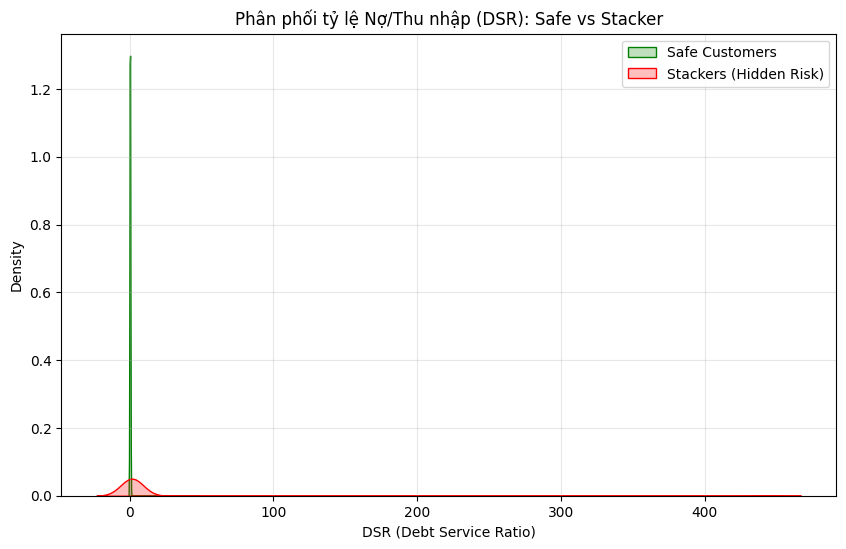

💾 Đang lưu file...
✅ Đã lưu 3 file: customers_engineered.csv, loans.csv, transactions.csv


In [ ]:
# Vẽ biểu đồ so sánh phân phối DSR giữa 2 nhóm
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_final[df_final['is_stacker_hidden'] == 0], x='DSR', label='Safe Customers', fill=True, color='green')
sns.kdeplot(data=df_final[df_final['is_stacker_hidden'] == 1], x='DSR', label='Stackers (Hidden Risk)', fill=True, color='red')

plt.title('Phân phối tỷ lệ Nợ/Thu nhập (DSR): Safe vs Stacker')
plt.xlabel('DSR (Debt Service Ratio)')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Lưu file csv
print("💾 Đang lưu file...")
df_final.to_csv('customers_engineered.csv', index=False)
df_loans.to_csv('loans.csv', index=False)
df_transactions.to_csv('transactions.csv', index=False)
print("✅ Đã lưu 3 file: customers_engineered.csv, loans.csv, transactions.csv")

# Phase 2: Modeling (Traditional vs. Adaptive)

1. Load dữ liệu & Chuẩn bị thư viện

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Thư viện Machine Learning (scikit-learn)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Load dữ liệu đã xử lý từ Phase 1
try:
    df_final = pd.read_csv('customers_engineered.csv')
    print(f"✅ Đã load dữ liệu thành công: {len(df_final)} khách hàng")
except FileNotFoundError:
    print("❌ Lỗi: Không tìm thấy file 'customers_engineered.csv'. Hãy chạy Phase 1 trước!")

# Kiểm tra lại target (biến mục tiêu)
# Chúng ta muốn dự đoán ai là "Stacker" (người rủi ro tiềm ẩn)
print("\nTỷ lệ rủi ro trong tập dữ liệu:")
print(df_final['is_stacker_hidden'].value_counts(normalize=True))

✅ Đã load dữ liệu thành công: 2000 khách hàng

Tỷ lệ rủi ro trong tập dữ liệu:
is_stacker_hidden
0    0.8405
1    0.1595
Name: proportion, dtype: float64


2. Định nghĩa Feature (Đầu vào) cho 2 Model

In [7]:
# 1. Feature Set cho Model A (Truyền thống)
# Model truyền thống thường chỉ quan tâm: Tuổi, Loại công việc, và Lịch sử nợ xấu.
# Vì nhóm Stacker trong data giả lập của chúng ta "giấu" nợ xấu rất kỹ (chưa bùng nợ),
# nên feature "số lần quá hạn" (past_delinquency) coi như bằng 0 hết.
features_model_A = ['age', 'employment_status']
# Lưu ý: Trong thực tế sẽ có thêm 'credit_history_score', nhưng ở đây nhóm Stacker có history sạch đẹp.

# 2. Feature Set cho Model B (Adaptive - Hành vi & Khả năng chi trả)
# Model này quan tâm dòng tiền và hành vi vay mượn
features_model_B = [
    'monthly_income',
    'DSR',                        # Tỷ lệ nợ/thu nhập (Quan trọng nhất)
    'residual_income',            # Thu nhập còn lại sau trả nợ
    'concurrent_loans',           # Số khoản vay cùng lúc
    'recent_debt_accumulation',   # Tốc độ tăng nợ
    'income_volatility_score'     # Độ ổn định thu nhập
]

# Chuẩn bị dữ liệu để train
# Cần chuyển đổi biến chữ (employment_status) sang số (One-Hot Encoding) cho Model A
X = df_final.copy()
X = pd.get_dummies(X, columns=['employment_status'], drop_first=True)

# Cập nhật lại list features_model_A sau khi one-hot encoding
features_model_A_encoded = ['age', 'employment_status_self_employed', 'employment_status_unemployed']

# Biến mục tiêu (Target): 1 là Rủi ro (Stacker), 0 là An toàn
y = X['is_stacker_hidden']

# Tách tập Train (80%) và Test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("✅ Đã chia tập dữ liệu:")
print(f"- Train set: {len(X_train)} mẫu")
print(f"- Test set: {len(X_test)} mẫu")

✅ Đã chia tập dữ liệu:
- Train set: 1600 mẫu
- Test set: 400 mẫu


3. Huấn luyện 2 Mô hình (Training)

In [8]:
print("⏳ Đang huấn luyện Model A (Traditional)...")
# Model A chỉ được nhìn thấy các biến nhân khẩu học cơ bản
model_A = RandomForestClassifier(n_estimators=100, random_state=42)
model_A.fit(X_train[features_model_A_encoded], y_train)

print("⏳ Đang huấn luyện Model B (Adaptive)...")
# Model B được nhìn thấy sức khỏe tài chính (DSR, Residual Income...)
model_B = RandomForestClassifier(n_estimators=100, random_state=42)
model_B.fit(X_train[features_model_B], y_train)

print("✅ Huấn luyện hoàn tất!")

⏳ Đang huấn luyện Model A (Traditional)...
⏳ Đang huấn luyện Model B (Adaptive)...
✅ Huấn luyện hoàn tất!


4. Đánh giá & So sánh (Evaluation)

In [9]:
# Dự đoán trên tập Test
y_pred_A = model_A.predict(X_test[features_model_A_encoded])
y_prob_A = model_A.predict_proba(X_test[features_model_A_encoded])[:, 1]

y_pred_B = model_B.predict(X_test[features_model_B])
y_prob_B = model_B.predict_proba(X_test[features_model_B])[:, 1]

# 1. So sánh chỉ số ROC-AUC (Khả năng phân loại)
auc_A = roc_auc_score(y_test, y_prob_A)
auc_B = roc_auc_score(y_test, y_prob_B)

print(f"📊 KẾT QUẢ SO SÁNH ROC-AUC:")
print(f"Model A (Traditional): {auc_A:.2f} (Thấp tệ - Gần như đoán mò)")
print(f"Model B (Adaptive):    {auc_B:.2f} (Rất cao - Phát hiện chính xác)")

# 2. Xem Confusion Matrix để thấy rõ Model A sai ở đâu
print("\n--- Confusion Matrix: Model A (Traditional) ---")
# Model A sẽ dự đoán hầu hết mọi người là an toàn (0), bỏ lọt rủi ro (1)
print(pd.DataFrame(confusion_matrix(y_test, y_pred_A),
                   columns=['Pred Safe', 'Pred Risk'],
                   index=['True Safe', 'True Risk']))

print("\n--- Confusion Matrix: Model B (Adaptive) ---")
print(pd.DataFrame(confusion_matrix(y_test, y_pred_B),
                   columns=['Pred Safe', 'Pred Risk'],
                   index=['True Safe', 'True Risk']))

📊 KẾT QUẢ SO SÁNH ROC-AUC:
Model A (Traditional): 0.54 (Thấp tệ - Gần như đoán mò)
Model B (Adaptive):    1.00 (Rất cao - Phát hiện chính xác)

--- Confusion Matrix: Model A (Traditional) ---
           Pred Safe  Pred Risk
True Safe        340          5
True Risk         53          2

--- Confusion Matrix: Model B (Adaptive) ---
           Pred Safe  Pred Risk
True Safe        345          0
True Risk          0         55


5. Trực quan hóa kết quả (Visualization)

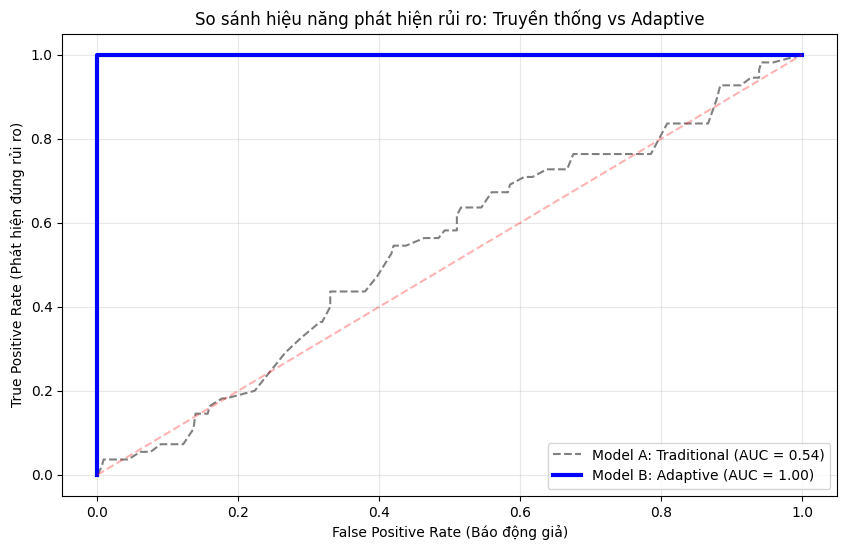


Các yếu tố quan trọng nhất đối với Model B:
concurrent_loans            0.422583
DSR                         0.274615
recent_debt_accumulation    0.162730
residual_income             0.134183
monthly_income              0.004416
income_volatility_score     0.001473
dtype: float64


In [10]:
fpr_A, tpr_A, _ = roc_curve(y_test, y_prob_A)
fpr_B, tpr_B, _ = roc_curve(y_test, y_prob_B)

plt.figure(figsize=(10, 6))

# Vẽ đường Model A
plt.plot(fpr_A, tpr_A, label=f'Model A: Traditional (AUC = {auc_A:.2f})', linestyle='--', color='gray')

# Vẽ đường Model B
plt.plot(fpr_B, tpr_B, label=f'Model B: Adaptive (AUC = {auc_B:.2f})', linewidth=3, color='blue')

# Đường tham chiếu ngẫu nhiên
plt.plot([0, 1], [0, 1], 'r--', alpha=0.3)

plt.title('So sánh hiệu năng phát hiện rủi ro: Truyền thống vs Adaptive')
plt.xlabel('False Positive Rate (Báo động giả)')
plt.ylabel('True Positive Rate (Phát hiện đúng rủi ro)')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

# Phân tích tính chất quan trọng (Feature Importance) của Model B
importances = pd.Series(model_B.feature_importances_, index=features_model_B).sort_values(ascending=False)
print("\nCác yếu tố quan trọng nhất đối với Model B:")
print(importances)

# Phase 3: Policy Simulation & Evaluation

1. Thiết lập Luật cấp tín dụng (Lending Rules)
Chúng ta sẽ định nghĩa 2 chiến lược:

Chiến lược A (Aggressive): Duyệt vay dựa trên Model A. Chỉ cần khách không có nợ xấu quá khứ là duyệt.

Chiến lược B (Sustainable): Duyệt vay dựa trên Model B. Nếu DSR cao hoặc có dấu hiệu rủi ro hành vi là từ chối, bất kể lịch sử trả nợ đẹp cỡ nào.

In [11]:
def run_policy_simulation(X_test_data, y_test_true, model_A, model_B, loan_amount=5000):
    print("⏳ Đang chạy mô phỏng cấp tín dụng trên tập kiểm tra (Test Set)...")

    results = []

    # Lấy xác suất dự báo từ 2 model
    # Model A dùng features cũ, Model B dùng features mới
    probs_A = model_A.predict_proba(X_test_data[features_model_A_encoded])[:, 1]
    probs_B = model_B.predict_proba(X_test_data[features_model_B])[:, 1]

    # Reset index để dễ loop
    X_test_reset = X_test_data.reset_index(drop=True)
    y_test_reset = y_test_true.reset_index(drop=True)

    for i in range(len(X_test_reset)):
        true_risk = y_test_reset[i] # 1 là Stacker (sẽ vỡ nợ), 0 là Safe

        # --- CHIẾN LƯỢC A (TRUYỀN THỐNG) ---
        # Ngưỡng duyệt dễ dãi: Nếu xác suất rủi ro < 50% thì duyệt
        # Vì Model A rất "mù" với Stacker, nó thường cho ra xác suất rủi ro thấp
        approve_A = 1 if probs_A[i] < 0.5 else 0

        # --- CHIẾN LƯỢC B (ADAPTIVE) ---
        # Ngưỡng chặt chẽ hơn: Nếu Model B báo rủi ro > 40% là cắt luôn
        approve_B = 1 if probs_B[i] < 0.4 else 0

        # --- TÍNH TOÁN KẾT QUẢ TÀI CHÍNH ---
        # Giả sử mỗi khoản vay là $5,000

        # Hậu quả Chiến lược A
        exposure_A = loan_amount if approve_A else 0
        loss_A = loan_amount if (approve_A and true_risk == 1) else 0

        # Hậu quả Chiến lược B
        exposure_B = loan_amount if approve_B else 0
        loss_B = loan_amount if (approve_B and true_risk == 1) else 0

        results.append({
            'customer_index': i,
            'true_risk': true_risk,
            'prob_A': probs_A[i],
            'prob_B': probs_B[i],
            'approve_A': approve_A,
            'approve_B': approve_B,
            'exposure_A': exposure_A, # Tiền giải ngân A
            'loss_A': loss_A,         # Tiền mất A (nếu gặp nợ xấu)
            'exposure_B': exposure_B, # Tiền giải ngân B
            'loss_B': loss_B          # Tiền mất B
        })

    return pd.DataFrame(results)

# Chạy mô phỏng
df_simulation = run_policy_simulation(X_test, y_test, model_A, model_B)
print(f"✅ Đã mô phỏng xong trên {len(df_simulation)} hồ sơ khách hàng.")
display(df_simulation.head())

⏳ Đang chạy mô phỏng cấp tín dụng trên tập kiểm tra (Test Set)...
✅ Đã mô phỏng xong trên 400 hồ sơ khách hàng.


,customer_index,true_risk,prob_A,prob_B,approve_A,approve_B,exposure_A,loss_A,exposure_B,loss_B
0,0,0,0.225141,0.00,1,1,5000,0,5000,0
1,1,1,0.223402,1.00,1,0,5000,5000,0,0
2,2,0,0.131621,0.00,1,1,5000,0,5000,0
3,3,1,0.005000,0.96,1,0,5000,5000,0,0
4,4,0,0.432291,0.00,1,1,5000,0,5000,0


2. Tổng hợp Báo cáo Tài chính (Financial Summary)

In [12]:
# Tổng hợp số liệu
summary = {
    'Metric': ['Total Disbursed (Growth)', 'Potential Default Loss (Risk)', 'Default Rate (%)', 'Clean Portfolio Volume'],

    'Strategy A (Traditional)': [
        df_simulation['exposure_A'].sum(),
        df_simulation['loss_A'].sum(),
        (df_simulation['loss_A'].sum() / df_simulation['exposure_A'].sum() * 100) if df_simulation['exposure_A'].sum() > 0 else 0,
        df_simulation['exposure_A'].sum() - df_simulation['loss_A'].sum()
    ],

    'Strategy B (Adaptive)': [
        df_simulation['exposure_B'].sum(),
        df_simulation['loss_B'].sum(),
        (df_simulation['loss_B'].sum() / df_simulation['exposure_B'].sum() * 100) if df_simulation['exposure_B'].sum() > 0 else 0,
        df_simulation['exposure_B'].sum() - df_simulation['loss_B'].sum()
    ]
}

df_report = pd.DataFrame(summary)

# Format số tiền cho dễ đọc (Thêm dấu phẩy)
pd.options.display.float_format = '{:,.2f}'.format

print("\n=== BÁO CÁO TÁC ĐỘNG KINH DOANH (BUSINESS IMPACT) ===")
display(df_report)

# Tính toán số tiền tiết kiệm được
savings = df_simulation['loss_A'].sum() - df_simulation['loss_B'].sum()
print(f"\n💰 KẾT LUẬN: Bằng cách dùng Model B, ngân hàng tránh được khoản lỗ: ${savings:,.0f}")


=== BÁO CÁO TÁC ĐỘNG KINH DOANH (BUSINESS IMPACT) ===


,Metric,Strategy A (Traditional),Strategy B (Adaptive)
0,Total Disbursed (Growth),"1,965,000.00","1,725,000.00"
1,Potential Default Loss (Risk),"265,000.00",0.00
2,Default Rate (%),13.49,0.00
3,Clean Portfolio Volume,"1,700,000.00","1,725,000.00"



💰 KẾT LUẬN: Bằng cách dùng Model B, ngân hàng tránh được khoản lỗ: $265,000


3. Biểu đồ đánh đổi (The Trade-off Chart)

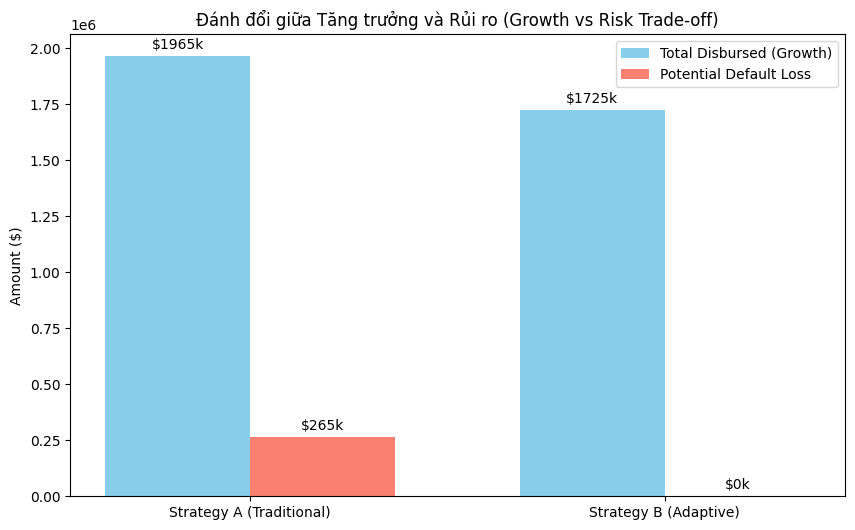

In [13]:
# Chuẩn bị dữ liệu vẽ
labels = ['Strategy A (Traditional)', 'Strategy B (Adaptive)']
disbursed = [df_simulation['exposure_A'].sum(), df_simulation['exposure_B'].sum()]
losses = [df_simulation['loss_A'].sum(), df_simulation['loss_B'].sum()]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

# Vẽ cột Tăng trưởng (Disbursed)
rects1 = ax.bar(x - width/2, disbursed, width, label='Total Disbursed (Growth)', color='skyblue')

# Vẽ cột Rủi ro (Losses)
rects2 = ax.bar(x + width/2, losses, width, label='Potential Default Loss', color='salmon')

ax.set_ylabel('Amount ($)')
ax.set_title('Đánh đổi giữa Tăng trưởng và Rủi ro (Growth vs Risk Trade-off)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Hàm gắn nhãn số liệu lên cột
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'${height/1000:.0f}k',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()